All important library import

In [91]:
import numpy as np
import pandas as pd
import sklearn as skt
%matplotlib inline
import math
import random
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import folium
import itertools
import scipy
import mplfinance as mpf
import yfinance as yf
from datetime import date
from keras.models import Sequential
from keras.layers import Dense,LSTM
import math
from sklearn.preprocessing import  MinMaxScaler

In [92]:
#date=input("Enter the date")
#tic=input("Enter the stock name")
start_date='2020-03-20'
end_date=date.today()
data=yf.download(tickers='^NSEI',start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed


In [93]:
data.reset_index(inplace=True)
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-20,8284.450195,8883.000000,8178.200195,8745.450195,8745.450195,1071500
1,2020-03-23,7945.700195,8159.250000,7583.600098,7610.250000,7610.250000,653500
2,2020-03-24,7848.299805,8036.950195,7511.100098,7801.049805,7801.049805,738400
3,2020-03-25,7735.149902,8376.750000,7714.750000,8317.849609,8317.849609,736900
4,2020-03-26,8451.000000,8749.049805,8304.900391,8641.450195,8641.450195,865600
5,2020-03-27,8949.099609,9038.900391,8522.900391,8660.250000,8660.250000,801500
6,2020-03-30,8385.950195,8576.000000,8244.000000,8281.099609,8281.099609,593300
7,2020-03-31,8529.349609,8678.299805,8358.000000,8597.750000,8597.750000,712700
8,2020-04-01,8584.099609,8588.099609,8198.349609,8253.799805,8253.799805,506300
9,2020-04-03,8356.549805,8356.549805,8055.799805,8083.799805,8083.799805,697000


Visualization of data

In [94]:
ma200=data.Close.rolling(200).mean()
ma100=data.Close.rolling(100).mean()

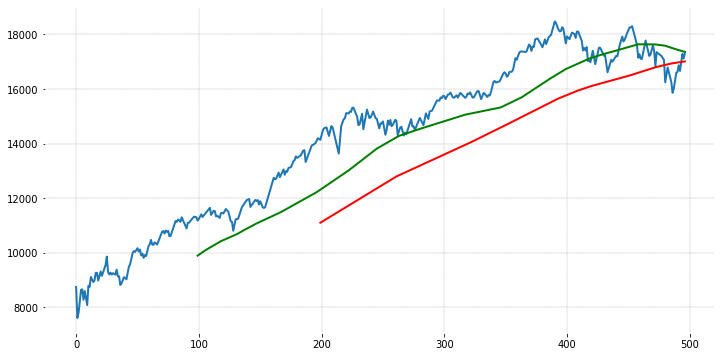

In [95]:
plt.figure(figsize=(12,6))
plt.plot(data.Close)
plt.plot(ma200,'r')
plt.plot(ma100,'g')
plt.show()

Visualization of data in all time frame

In [96]:

fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
fig.update_xaxes(
    title_text='Date',
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1,label='1M',step='month',stepmode='backward'),
            dict(count=6,label='6M',step='month',stepmode='backward'),
            dict(count=1,label='YTD',step='year',stepmode='todate'),
            dict(count=1,label='1Y',step='year',stepmode='backward'),
            dict(step='all')

        ])
    )
)
fig.update_layout(
    title={
        'text':'Nifty Bank',
        'y':0.9,
        'x':0.5,
        'xanchor':'center',
        'yanchor':'top'

    }
)
fig.show()

Volume chart visualizations

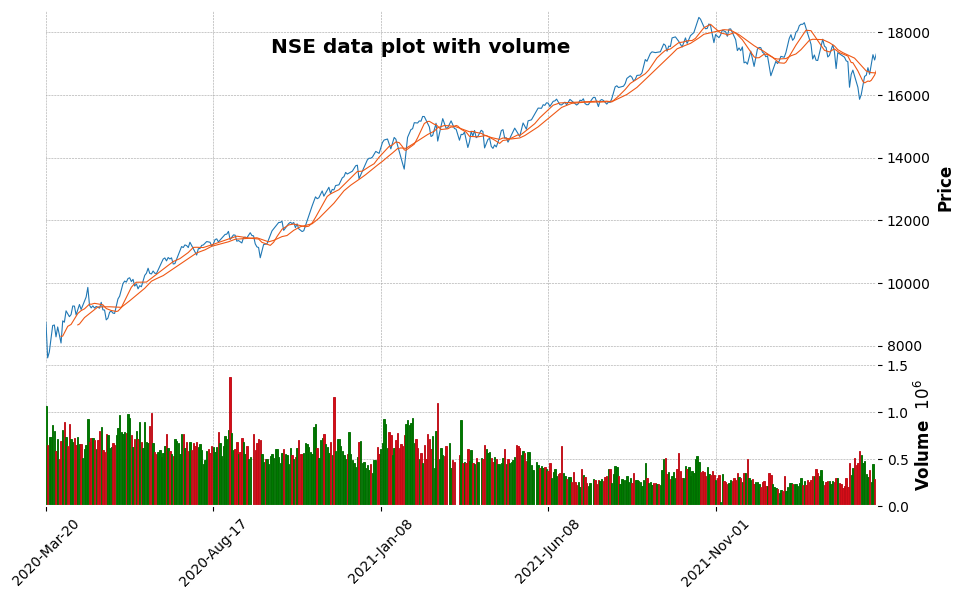

In [97]:
data.index=pd.DatetimeIndex(data['Date'])
mpf.plot(data, figratio=(10, 6), type="line", 
         mav=(10,20), volume=True,
         title = "NSE data plot with volume",
         tight_layout=True, style="charles")

Plotting date vs the close prices 

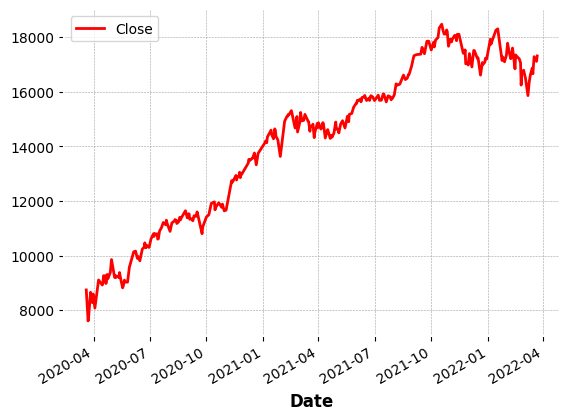

In [98]:
data.plot('Date','Close',color='red')
plt.show()

Extract only top 100 row and plot

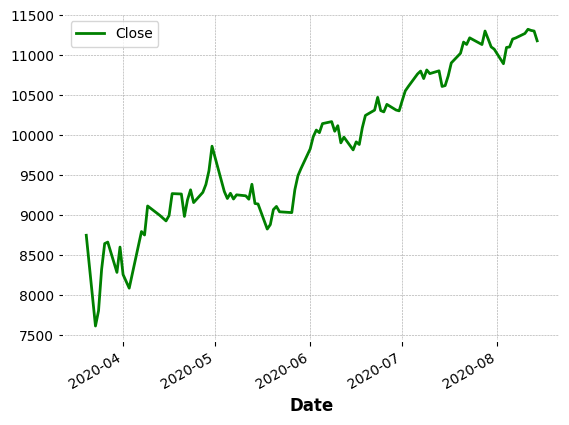

In [99]:
new_data=data.head(100)
new_data.plot('Date','Close',color='green')
plt.show()

In [100]:
close_data = data.filter(['Close'])
dataset = close_data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


Building LSTM Model

In [101]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

Compiling the Model

In [102]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

288/288 [==============================] - 12s 27ms/step - loss: 0.0057


Testing the model on testing data

In [103]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Error Calculation

In [104]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

651.2110407222922


Make Predictions

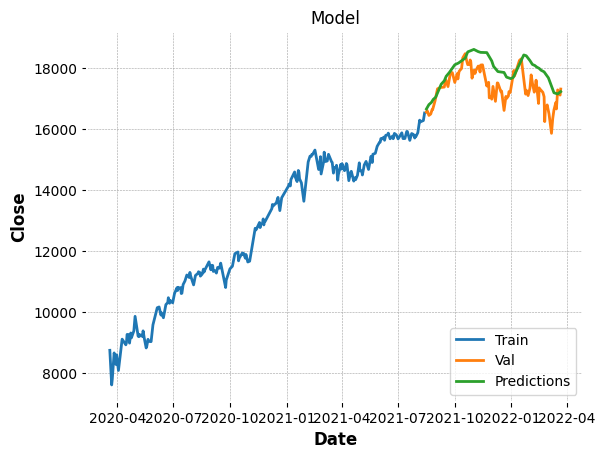

In [105]:
train = data[:training_data_len]
valid = data[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()